In [ ]:
!pip install Bio
!pip install torchviz
from Bio import SeqIO
import random
import matplotlib.pyplot as plt
import torch
from torch import nn
import math
from torch.autograd import Variable
import os
import numpy as np
import torchviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.2/279.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached 

In [ ]:
nucleotide_dict = {"A": 0, "G": 1, "C": 2, "T": 3}

random.seed(28)
torch.manual_seed(28)

In [ ]:
def break_into_fragments(sequence, num_fragments, max_length_of_fragment):
    fragments = []
    while len(fragments) < num_fragments:
        index = random.randrange(0, len(sequence) - max_length_of_fragment)
        fragments += [sequence[index:index + max_length_of_fragment]]
    return fragments


def create_images_for_fragment(fragment):
    x_vals = [i for i in range(len(fragment))]
    A_vals = [0]*len(fragment)
    G_vals = [0]*len(fragment)
    C_vals = [0]*len(fragment)
    T_vals = [0]*len(fragment)

    for idx, nucleotide in enumerate(fragment):
        if nucleotide == "A":
            A_vals[idx] += 1
        if nucleotide == "G":
            G_vals[idx] += 1
        if nucleotide == "C":
            C_vals[idx] += 1
        if nucleotide == "T":
            T_vals[idx] += 1

    #plt.plot(x_vals, A_vals, lw=0.4)
    #plt.plot(x_vals, G_vals, lw=0.4)
    #plt.plot(x_vals, C_vals, lw=0.4)
    #plt.plot(x_vals, T_vals, lw=0.4)
    #plt.savefig(filename)
    return A_vals, G_vals, C_vals, T_vals


def create_tensor_for_fragment(fragment):
    numerical_frag = []
    for nucleotide in fragment:
        numerical_frag += [nucleotide_dict[nucleotide]]
    return numerical_frag

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
fasta_sequences = SeqIO.parse(open("/content/drive/MyDrive/10708/10708 Project/covid_19.fasta"),'fasta')
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)

max_length_sequence_fragment = 50
num_training_data = 1024


fragments = break_into_fragments(sequence, num_training_data, max_length_sequence_fragment)
train_data = torch.empty((num_training_data, max_length_sequence_fragment, 4))


for idx, fragment in enumerate(fragments):
    A_vals, G_vals, C_vals, T_vals = create_images_for_fragment(fragment)
    train_data[idx, :, 0] = torch.Tensor(A_vals)
    train_data[idx, :, 1] = torch.Tensor(G_vals)
    train_data[idx, :, 2] = torch.Tensor(C_vals)
    train_data[idx, :, 3] = torch.Tensor(T_vals)


In [8]:
train_labels = torch.zeros(num_training_data)
train_set = [(train_data[i], train_labels[i]) for i in range(num_training_data)]

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, layer1, layer2, layer3, dropout):
        super().__init__()
        self.linear1 = nn.Linear(200, layer1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout) #0.3
        self.linear2 = nn.Linear(layer1, layer2) #800,400
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.linear3 = nn.Linear(layer2, layer3) #400, 64
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout)
        self.linear4 = nn.Linear(layer3, 1)
        self.sigmoid = nn.Sigmoid()

        #self.model = nn.Sequential(
        #    nn.Linear(4, 256),
        #    nn.ReLU(),
        #    nn.Dropout(0.3),
        #    nn.Linear(256, 128),
        #    nn.ReLU(),
        #    nn.Dropout(0.3),
        #    nn.Linear(128, 64),
        #    nn.ReLU(),
        #    nn.Dropout(0.3),
        #    nn.Linear(64, 1),
        #    nn.Sigmoid(),
        #)

    def forward(self, x):
        #print(x.shape)
        linear1 = self.linear1(x)
        #print(linear1.shape)
        relu1 = self.relu1(linear1)
        dropout1 = self.dropout1(relu1)
        #print(dropout1.shape)
        linear2 = self.linear2(dropout1)
        #print(linear2.shape)
        relu2 = self.relu2(linear2)
        dropout2 = self.dropout2(relu2)
        #print(dropout2.shape)
        linear3 = self.linear3(dropout2)
        #print(linear3.shape)
        relu3 = self.relu3(linear3)
        dropout3 = self.dropout3(relu3)
        #print(dropout3.shape)
        linear4 = self.linear4(dropout3)
        #print(linear4.shape)
        output = self.sigmoid(linear4)
        #output = self.model(x)
        return output

In [ ]:
class Generator(nn.Module):
    def __init__(self, layer1, layer2):
        super().__init__()

        self.linear1 = nn.Linear(200, layer1)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(layer1, layer2) #400,800
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(layer2, 200)
        self.tanh = nn.Tanh()

        #self.model = nn.Sequential(
        #    nn.Linear(4, 16),
        #    nn.ReLU(),
        #    nn.Linear(16, 32),
        #    nn.ReLU(),
        #    nn.Linear(32, 4),
        #)


    def forward(self, x):
        #print("input", x.shape)
        linear1 = self.linear1(x)
        #print("linear", linear1.shape)
        relu1 = self.relu1(linear1)
        #print("relu", relu1.shape)
        linear2 = self.linear2(relu1)
        #print("linear", linear2.shape)
        relu2 = self.relu2(linear2)
        #print("relu", relu2.shape)
        linear3 = self.linear3(relu2)
        #print("linear", linear3.shape)
        output = self.tanh(linear3)
        #output = self.model(x)
        return output

In [ ]:
discriminator = Discriminator(400, 400, 200, 0.3)
generator = Generator(400, 400)

lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [ ]:
print("Training Model...")

discriminator_loss = []
generator_loss = []

for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):

        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((real_samples.shape))

        generated_samples = generator(latent_space_samples.reshape((32,200)))
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples.reshape((32,50,4))))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )


        #print("Training Discriminator")
        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples.reshape((64,200)))
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((real_samples.shape))

        #print("Training Generator")
        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples.reshape((32, 200)))
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()


        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
    discriminator_loss += [loss_discriminator.detach().numpy()]
    generator_loss += [loss_generator.detach().numpy()]


Training Model...
Epoch: 0 Loss D.: 0.03788590431213379
Epoch: 0 Loss G.: 4.562595367431641
Epoch: 10 Loss D.: 0.347008615732193
Epoch: 10 Loss G.: 2.848043203353882
Epoch: 20 Loss D.: 0.14761726558208466
Epoch: 20 Loss G.: 6.352280616760254
Epoch: 30 Loss D.: 0.01986563950777054
Epoch: 30 Loss G.: 6.7848920822143555
Epoch: 40 Loss D.: 0.04231434315443039
Epoch: 40 Loss G.: 4.885881423950195
Epoch: 50 Loss D.: 0.03635513037443161
Epoch: 50 Loss G.: 5.845926761627197
Epoch: 60 Loss D.: 0.0340065136551857
Epoch: 60 Loss G.: 5.089803218841553
Epoch: 70 Loss D.: 0.07823590934276581
Epoch: 70 Loss G.: 7.250543594360352
Epoch: 80 Loss D.: 0.026711663231253624
Epoch: 80 Loss G.: 6.426463603973389
Epoch: 90 Loss D.: 0.18981313705444336
Epoch: 90 Loss G.: 4.711756229400635
Epoch: 100 Loss D.: 0.08540912717580795
Epoch: 100 Loss G.: 10.587861061096191
Epoch: 110 Loss D.: 0.1315068006515503
Epoch: 110 Loss G.: 5.655147552490234
Epoch: 120 Loss D.: 0.27596592903137207
Epoch: 120 Loss G.: 4.0455365

In [ ]:
torch.save(discriminator.state_dict(), '/content/drive/MyDrive/PGM Final Project/Discriminator_2.pth')
torch.save(generator.state_dict(), '/content/drive/MyDrive/PGM Final Project/Generator_2.pth')

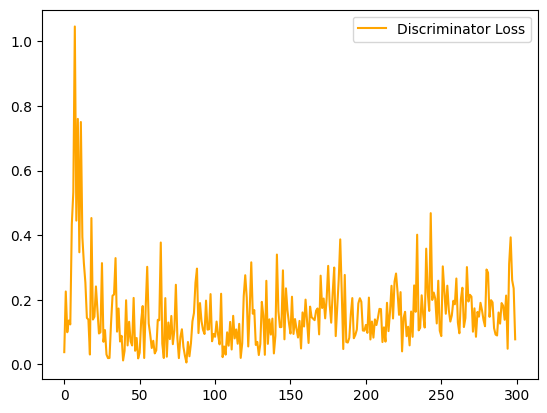

In [ ]:
x_vals = [i for i in range(len(discriminator_loss))]
plt.plot(x_vals, discriminator_loss, color = "orange", label = "Discriminator Loss")
plt.legend()
plt.show()

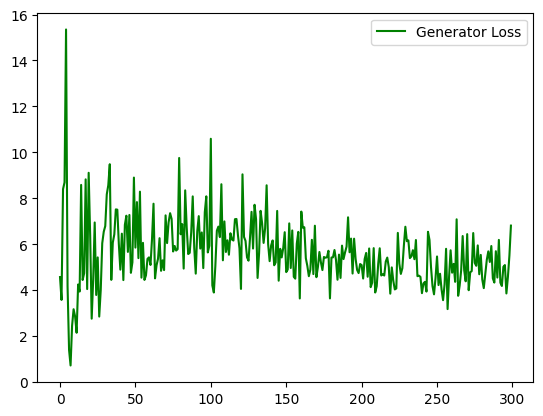

In [ ]:
plt.plot(x_vals, generator_loss, color = "green", label = "Generator Loss")
plt.legend()
plt.show()

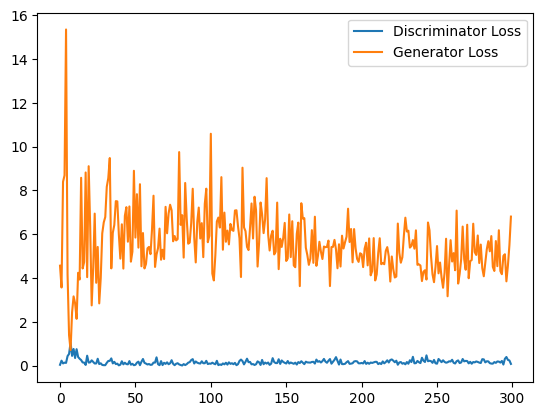

In [ ]:
plt.plot(x_vals, discriminator_loss, label = "Discriminator Loss")
plt.plot(x_vals, generator_loss, label = "Generator Loss")
plt.legend()
plt.show()

In [ ]:
discriminator = Discriminator(400, 400, 200, 0.3)
generator = Generator(400, 400)

discriminator.load_state_dict(torch.load('/content/drive/MyDrive/PGM Final Project/Discriminator_2.pth'))
generator.load_state_dict(torch.load('/content/drive/MyDrive/PGM Final Project/Generator_2.pth'))

<All keys matched successfully>

In [ ]:
sequences = []
while len(sequences) < 120:
  latent_space_samples = torch.randn(batch_size, 200)
  generated_samples = generator(latent_space_samples)
  generated_samples = generated_samples.reshape((batch_size, 50, 4)).detach().numpy()

  for sample in generated_samples:
    sequence = ""
    for nucleotide in sample:
      idx = np.argmax(nucleotide)
      if idx == 0:
        sequence += "A"
      if idx == 1:
        sequence += "G"
      if idx == 2:
        sequence += "C"
      if idx == 3:
        sequence += "T"
    sequences += [sequence]

print(sequences)

['TATAGTGACATGAAGGGCATCACTTTTACAATTAAAAAGAAGAACAATTA', 'TCGGATGTGATCATAGGACTGCATTTAAGGGTTTTACTGAAAGTTTATTA', 'TCGAAGGAATTCCAGATTCTTACAAAGGAATAAAAGTAATAAGTAGCTCA', 'TAATAAGTTTTATACGCCCTGTCTATATTGTTCTGAGGCCAGAGTTATTC', 'TAGGCAGATTTCCTGTGACGGCTTTTCAGTATTTAATTGGAGACCAAGTT', 'TTAGATGATTTCCACATACTGACTGAATCAATTACAGGGACAATTTTTCT', 'TAGACTAACATCACGGGACTCCCTTTAAAAATCGCGGGGAAGAACAATTA', 'TTTGATGAAAAACTAACAATTACTCAATCAATTTAACGGCTAATCGATCA', 'TCTAACTGCTTCACCTGCAGCACTTTAACAATTACATGAAAGGATAATTA', 'AAGGCTGAAATCACTGACATGCGTTTAACAGTCAATGTTAACATAGAGTT', 'TTGAATAAATTCACAAAAGTCCTTGACTGTTTTTTATTGACTAATTATAA', 'CAGGATGTGTTCTTAGTGCTGCATACACTACTTCTACTCAAAGGCTAGCA', 'TATAATGTATTACCTGACCGCCCTTAGAGAGTCAGAGGATAGAGTTAGTG', 'TATATTGTTTACAACTTATGTACAAAAAAATTACAATTATGAGTTAATTT', 'TAAACATAATAAGAAGGAACCAATTTATAGCTCGGGAGGTCGATTTACCA', 'CTTAATGAAAAGATGTGAATTTCTAGTCAGATTAAACAGAAGGTCAATCT', 'TCTGACTGGTTCATCTGGCGCACTTTCACATTTACATGAAAGGGTAATAC', 'TTTAACGAAAAAAAATCAACCAATAGATAGGTTTAATAGACGGTTTCTTT', 'TCGAAATCTATAGTGGTTCCCCCTTT

In [ ]:
with open("/content/drive/MyDrive/10708 Project/Generated_Sequences/GAN_Generated_Sequences.txt", "w") as f:
  for sequence in sequences[:120]:
    f.write(sequence)
    f.write("\n")


In [ ]:
discriminator = Discriminator(400, 400, 200, 0.3)
generator = Generator(400, 400)

discriminator.load_state_dict(torch.load('/content/drive/MyDrive/PGM Final Project/Discriminator_2.pth'))
generator.load_state_dict(torch.load('/content/drive/MyDrive/PGM Final Project/Generator_2.pth'))

batch = next(iter(train_loader))


latent_space_samples = torch.randn((batch[0].shape))
genr_yhat = generator(latent_space_samples.reshape((32,200)))
discr_yhat = discriminator(genr_yhat)

In [ ]:
dot = make_dot(genr_yhat, params=dict(list(generator.named_parameters())))
dot.render('/content/drive/MyDrive/PGM Final Project/generator.png')

'/content/drive/MyDrive/PGM Final Project/generator.png.pdf'

In [ ]:
dot = make_dot(discr_yhat, params=dict(list(discriminator.named_parameters())))
dot.render('/content/drive/MyDrive/PGM Final Project/discriminator.png')

'/content/drive/MyDrive/PGM Final Project/discriminator.png.pdf'